# 학습 관련 기술들
- 매개변수 갱신
- 가중치의 초깃값
- 배치 정규화
- 바른 학습을 위해
- 적절한 하이퍼파라미터 값 찾기

## 개요 

이번 장에서 설명하는 기법을 이용하면 학습의 효율과 정확도를 높일 수 있다.

## 매개변수 갱신
- 확률적 경사 하강법(SGD) 복습
- SGD의 단점
- 모멘텀
- AdaGrad
- Adam

### SGD
$ W \leftarrow W - \eta \frac{\partial L}{\partial W} $  
> $\frac{\partial L}{\partial W}$은 $W$에 대한 손실 함수의 기울기  
$\eta$는 학습률

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 모멘텀 (Momentum)
왜 얘만 한글이지 외롭지 않게 괄호를 붙여주었다 ^^  

$v \leftarrow \alpha v - \eta \frac{\partial L}{\partial W}$   
$W \leftarrow W + v$  
아까랑 다른건 $v$가 생긴거고 이 $v$는 단순히 아까에서 $\alpha v$만 더해진거임
> $v$는 속도, $\alpha v$는 지면 마찰, 공기 저항과 같은 역할


In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, value in params.items():
                self.v[key] = np.zeros_like(value)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### AdaGrad
Adaptive Gradient : 처음에는 크게 학습하다가 조금씩 작게 학습 = 학습률을 점차 줄여가는 방법  
매개변수 전체의 학습률 $\eta$를 감소시키는게 아니라 **각각의** 매개변수에 맞춘 학습률을 적용시킴  

$h \leftarrow h + \frac{\partial L}{\partial W} ⊙ \frac{\partial L}{\partial W}$  
$W \leftarrow W + \eta \frac{1}{\sqrt{h}}\frac{\partial L}{\partial W}$
> $h$는 기존 기울기 값을 계속 더해줌  
학습률에 $\frac{1}{\sqrt{h}}$을 곱해 학습률 조정 :**많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다**, 즉 갱신 값의 움직임이 억제한다.  
⊙는 원소별 곱셈 `np.dot`이 아니라 단순한 스칼라 곱 `*`


In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, value in params.items():
                self.h[key] = np.zeros_like(value)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / np.sqrt(self.h[key] + 1e-7)            

### Adam
Adaptive momentum = AdaGrad + Momentum  
책에서는 http://arxiv.org/abs/1412.6980v8 의 논문을 참고하라하고 자세한 설명은 되어있지 않음  
$\beta_1$은 일차 모멘텀용 계수, 0.9가 좋음  
$\beta_2$는 이차 모멘텀용 계수, 0.999가 좋음

In [5]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


### 갱신 방법 직접 비교

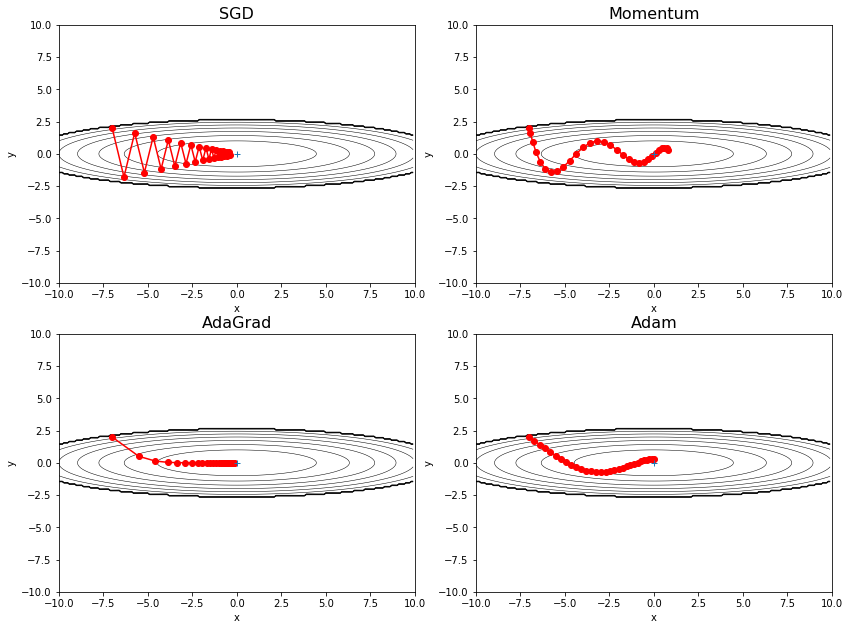

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

def draw(idx, key, x_history, y_history):
    xlim = 10
    ylim = 10
    x = np.arange(-xlim, xlim, 0.1)
    y = np.arange(-ylim, ylim, 0.1)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    ax = subplots[idx]
    ax.plot(x_history, y_history, 'o-', color="red")
    ax.contour(X, Y, Z, linewidths=0.5, colors='k')
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.plot(0, 0, '+')
    ax.set_title(key, fontsize=16)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

init_pos = (-7.0, 2.0)
params = {
    "x": init_pos[0],
    "y": init_pos[1],
}

grads = {
    "x": 0,
    "y": 0,
}


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1, momentum=0.9)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

fig, subplots = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
subplots = subplots.flatten()
plt.tight_layout(pad=3, w_pad=3, h_pad=3)

for idx, key in enumerate(optimizers):
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
        
    draw(idx, key, x_history, y_history)
    
plt.show();

**SGD**와 **Adam**이 주로 쓰임

### MNIST 데이터셋으로 비교
각 층의 히든 노드가 100개이고, 히든 레이어가 5층인 뉴럴넷을 사용한다.  
그러기 위해선 `Multil Layer Net`을 만들어야한다.  
기존의 `Two Layer Net`보다 유연하고 조립성이 증가한 뉴럴넷  
`Github`에 올라와 있는 `MultiLayerNet`을 참고하여 적절히 편집함

In [7]:
import numpy as np
np.random.seed(0)

In [8]:
from collections import OrderedDict
from common.layers import Relu, Sigmoid, SoftmaxWithLoss, Affine

class MultiLayerNet:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu', 'sigmoid' 혹은 커스텀함수
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01)
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std=0.01):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        if activation in ['sigmoid', 'relu']:
            activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        else:
            # 직접 커스텀 함수로 전달한다면
            active_func = activation
            active_func_name = "custom"
            activation_layer = {active_func_name: active_func}
            activation = active_func_name
    
        # 레이어 연결
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        # 가중치 초기화
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            
            # 뒤에서 배울 가중치 초기화
            # 이부분이 없으면 학습이 진행되지 않음
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        """
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        loss = self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


In [9]:
import matplotlib.pyplot as plt
from mnist import load

dataset = load(normalize=True, one_hot_label=True)
x_train = dataset["train_img"]
t_train = dataset["train_label"]

train_size = x_train.shape[0]
batch_size = 128
max_iter = 2000

optimizers = {}
optimizers["SGD"] = SGD()
optimizers["Momentum"] = Momentum()
optimizers["AdaGrad"] = AdaGrad()
optimizers["Adam"] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(784, [50, 50, 50, 50], 10, 'relu', 'relu')
    train_loss[key] = []
    
for i in range(max_iter):
    mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[mask]
    t_batch = t_train[mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 500 == 0:
        print("=======  iter : {:4}  =======".format(i))
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print("{} : {}".format(key, loss))

=======  iter :    0  =======
Momentum : 2.338722926913087
Adam : 2.224872542082074
SGD : 2.301145986881658
AdaGrad : 2.577532182845065
=======  iter :  500  =======
Momentum : 0.15762209995590445
Adam : 0.1666663694947888
SGD : 0.5014863238456695
AdaGrad : 0.10416986954555109
=======  iter : 1000  =======
Momentum : 0.20033076309223627
Adam : 0.17706315963411867
SGD : 0.39150768624232146
AdaGrad : 0.12757085876913915
=======  iter : 1500  =======
Momentum : 0.1123731591285208
Adam : 0.07257968980807489
SGD : 0.20792538568283742
AdaGrad : 0.07745435854919576


In [10]:
def smooth_curve(x, beta=2):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, beta)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

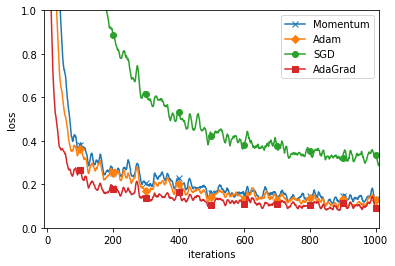

In [11]:
markers = {
    "SGD": "o",
    "Momentum": "x",
    "AdaGrad": "s",
    "Adam": "D",
}
x = np.arange(max_iter)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.xlim(-10, 1010)
plt.legend()
plt.show();

`AdaGrad`가 가장 빠르게 나타나나 학습률과 신경망의 구조에 따라 결과가 달라진다.  
일반적으로 `SGD`보다는 다른 세 기법이 빠르고 정확함

## 가중치의 초깃값
- Xavier 초깃값
- He 초깃값

지금까지는 `0.01 * np.random.randn(10,100)`처럼 표준편차가 0.01인 정규분포를 사용함  
이럴 경우 아까 `optimizer별 MNIST 학습`에서도 확인할 수 있듯이 학습이 이루어 지지 않을 수 도 있거나 느림.

### 히스토그램

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from common.functions import sigmoid, relu

np.random.seed(42)
node_num = 100
layer_num = 7
nodes = [node_num] * layer_num
hidden_layer_size = len(nodes)

In [13]:
def activate(func, weight_init):
    activations = {}
    for i in range(hidden_layer_size):
        if i == 0:
            x = np.random.randn(1000, 100)
        w = weight_init
        y = x @ w
        z = func(y)
        activations[i] = z
        x = z
    return activations

In [14]:
def show_histogram(activations):
    fig, ax = plt.subplots(1, len(activations), sharey=True, figsize=(9, 2))
    ax = ax.flatten()
    for idx, item in activations.items():
        ax[idx].set_title(str(idx+1) + "-layer")
        ax[idx].set_xlim(0, 1)
        ax[idx].set_ylim(0, 10000)
        # hist의 두번째 인자는 얼마나 잘게 쪼갤지에 대한 값
        ax[idx].hist(item.flatten(), 25, range=(0, 1))
    plt.show();

### 표준편차 1일 때

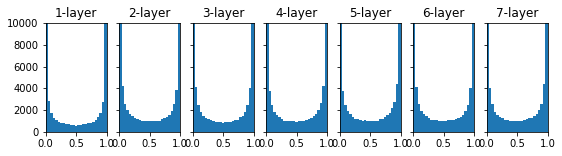

In [15]:
w = np.random.randn(node_num, node_num) * 1
activations = activate(sigmoid, w)
show_histogram(activations)

### 표준편차 0.01일 때

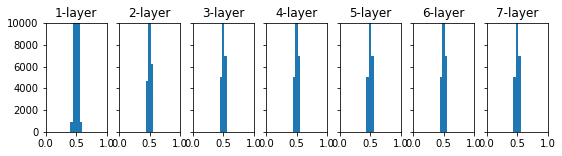

In [16]:
w = np.random.randn(node_num, node_num) * 0.01
activations = activate(sigmoid, w)
show_histogram(activations)

### Xavier (사비에르) 초깃값

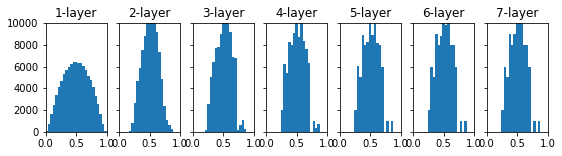

In [17]:
w = np.random.randn(node_num, node_num) * np.sqrt(1 / node_num)
activations = activate(sigmoid, w)
show_histogram(activations)

#### sigmoid -> tanh

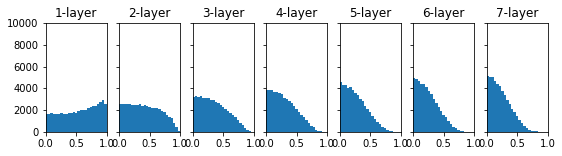

In [18]:
w = np.random.randn(node_num, node_num) * np.sqrt(1 / node_num)
activations = activate(np.tanh, w)
show_histogram(activations)

#### sigmoid -> relu

### He (히) 초깃값
활성화 함수가 `Relu`일 때 특화된 초깃값

#### Relu + He

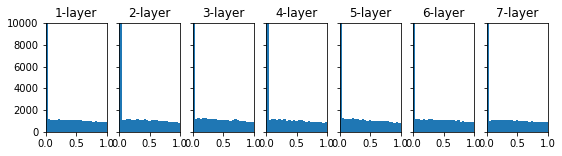

In [19]:
w = np.random.randn(node_num, node_num) * np.sqrt(2 / node_num)
activations = activate(relu, w)
show_histogram(activations)

#### Relu + 0.01

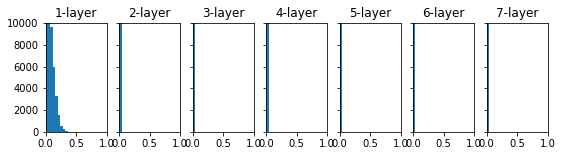

In [20]:
w = np.random.randn(node_num, node_num) * 0.01
activations = activate(relu, w)
show_histogram(activations)

#### Relu + Xavier

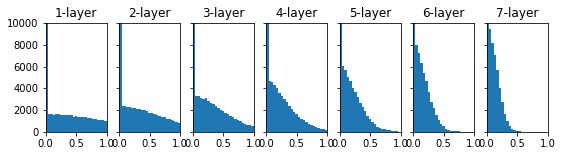

In [21]:
w = np.random.randn(node_num, node_num) * np.sqrt(1 / node_num)
activations = activate(relu, w)
show_histogram(activations)

### MNIST 데이터셋으로 비교

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load
from common.multi_layer_nn import MultiLayerNet
from common.optimizer import SGD

dataset = load(normalize=True)
x_train = dataset["train_img"]
t_train = dataset["train_label"]

train_size = x_train.shape[0]
batch_size = 128
max_iter = 2000

weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD()

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


for i in range(max_iter):
    mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[mask]
    t_batch = t_train[mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 500 == 0:
        print("=======  iter : {:4}  =======".format(i))
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print("{} : {}".format(key, loss))

=======  iter :    0  =======
He : 2.3651401215421295
std=0.01 : 2.3025277448982617
Xavier : 2.310174309438612
=======  iter :  500  =======
He : 0.4206265687611705
std=0.01 : 2.3023027050893052
Xavier : 0.9406570483985167
=======  iter : 1000  =======
He : 0.24861762713744134
std=0.01 : 2.304322268827358
Xavier : 0.47720537096715165
=======  iter : 1500  =======
He : 0.14345941140931912
std=0.01 : 2.3041421558567103
Xavier : 0.2713515418365128


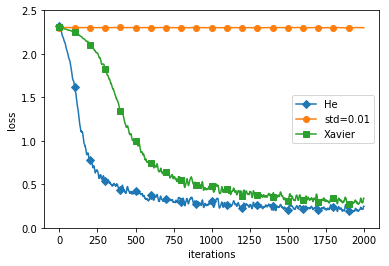

In [25]:
markers = {
    'std=0.01': 'o',
    'Xavier': 's',
    'He': 'D'
}
x = np.arange(max_iter)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show();

## 배치 정규화

## 바른 학습을 위해
- 오버피팅이란
- 가중치 감소
- 드롭아웃
- 앙상블 학습

## 적절한 하이퍼파라미터 값 찾기
- 검증 데이터
- 하이퍼파라미터 최적화